/tmp/ipykernel_17610/2490452821.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('tab10', 10))  # 10 discrete colors for values 0-9)


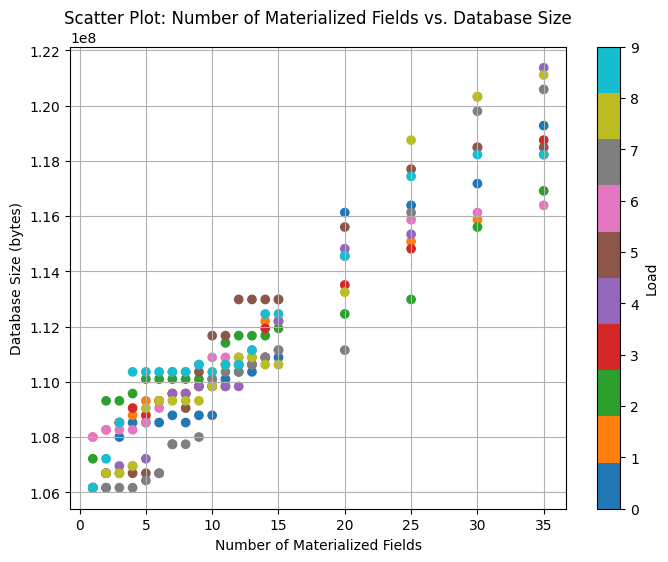

In [3]:
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Small dataset, 500 queries - m1, m2, m3 ...
# RESULTS_PATH = "../results/load-based-N-fields/tpch/2025-03-17-8H"
# Medium dataset, 500 queries, WITHOUT q5
RESULTS_PATH = "../results/load-based-N-fields/tpch/2025-03-26-15H"


# Read the CSV file
meta_results = pd.read_csv(RESULTS_PATH + "/meta_results.csv")

# Function to count the number of materialized fields from the string representation
def count_materialized_fields(s: str):
    try:
        # Converts the string representation to a python list
        fields = ast.literal_eval(s)
        return len(fields)
    except Exception as e:
        print(e)

# Create a new column with the number of materialized fields
meta_results["num_materialized_fields"] = meta_results["Materialization"].apply(count_materialized_fields)


# Exclude rows where Test is full_materialization
meta_results_no_full = meta_results[(meta_results["Test"] != "full_materialization") & (meta_results["Test"] != "schema_based_materialization")]

# Create the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    meta_results_no_full["num_materialized_fields"],
    meta_results_no_full["Database size"],
    c=meta_results_no_full["Load"],
    cmap=plt.cm.get_cmap('tab10', 10))  # 10 discrete colors for values 0-9)
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Database Size (bytes)")
plt.title("Scatter Plot: Number of Materialized Fields vs. Database Size")
plt.colorbar(scatter, label='Load')
plt.grid(True)
plt.show()

/tmp/ipykernel_17610/2214664140.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('tab10', 10))


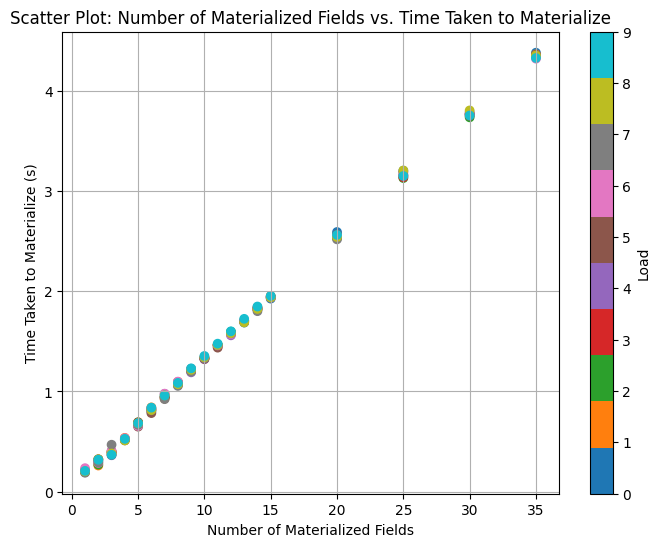

In [4]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    meta_results_no_full["num_materialized_fields"],
    meta_results_no_full["Time to prepare db"],
    c=meta_results_no_full["Load"],
    cmap=plt.cm.get_cmap('tab10', 10))
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Time Taken to Materialize (s)")
plt.title("Scatter Plot: Number of Materialized Fields vs. Time Taken to Materialize")
plt.colorbar(scatter, label='Load')
plt.grid(True)
plt.show()

/tmp/ipykernel_17610/3300701398.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('tab10', 10))


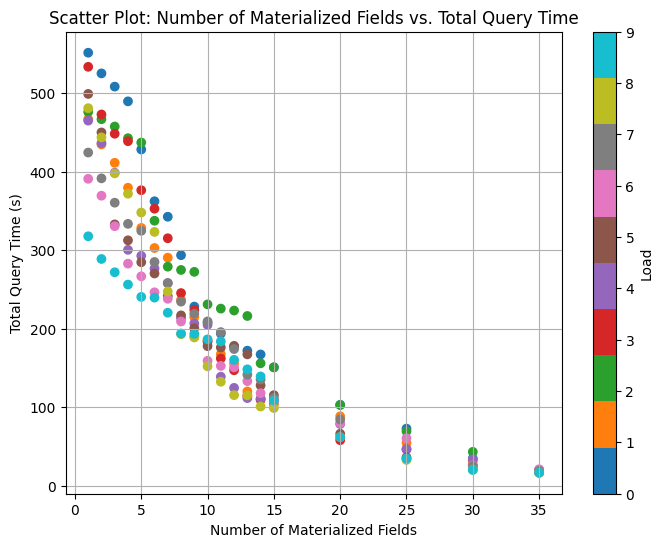

In [5]:
subset = meta_results[(meta_results["Total query time"] > 0) & (meta_results["Test"] != "full_materialization") & (meta_results["Test"] != "schema_based_materialization")]
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    subset["num_materialized_fields"],
    subset["Total query time"],
    c=subset["Load"],
    cmap=plt.cm.get_cmap('tab10', 10))

plt.colorbar(scatter, label='Load')
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Total Query Time (s)")
plt.title("Scatter Plot: Number of Materialized Fields vs. Total Query Time")
plt.grid(True)
plt.show()

/tmp/ipykernel_17610/3834283674.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('tab10', 10))


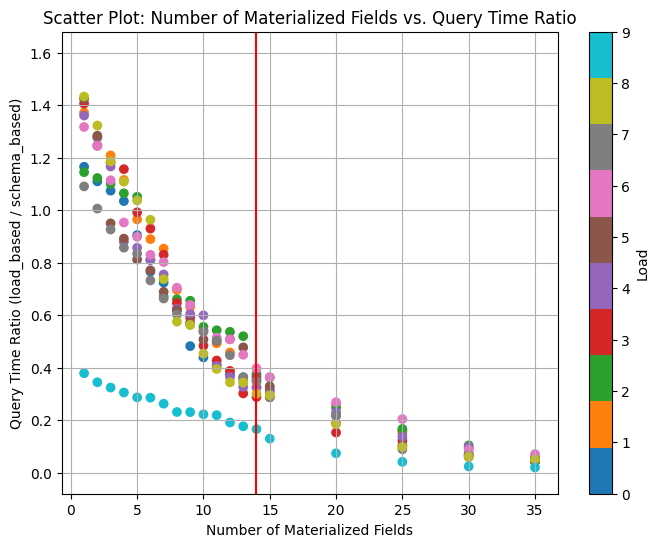

In [6]:
subset = meta_results[(meta_results["Total query time"] > 0)]
# Subset rows where Test starts with "load_based_t"
load_based = subset[subset["Test"].str.startswith("load_based_m")]

# Subset rows with Test equal to "schema_based_materialization"
schema_based = subset[subset["Test"] == "schema_based_materialization"]

# Merge the two dataframes on the columns "Query proportion", "Majority proportion", and "Load"
merged = pd.merge(
    load_based,
    schema_based,
    on=["Query proportion", "Majority proportion", "Load"],
    suffixes=('_load', '_schema')
)
# Compute the ratio between the total query time of the load_based row and the corresponding schema_based row
merged["query_time_ratio"] = merged["Total query time_load"] / merged["Total query time_schema"]

# Create the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    merged["num_materialized_fields_load"],
    merged["query_time_ratio"],
    c=merged["Load"],
    cmap=plt.cm.get_cmap('tab10', 10))
plt.colorbar(scatter, label='Load')

plt.axline([16, 0], [16, 1.6], color='red')
plt.axline([0, 1], [1, 1], color="red")
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Query Time Ratio (load_based / schema_based)")
plt.title("Scatter Plot: Number of Materialized Fields vs. Query Time Ratio")
plt.grid(True)
plt.show()


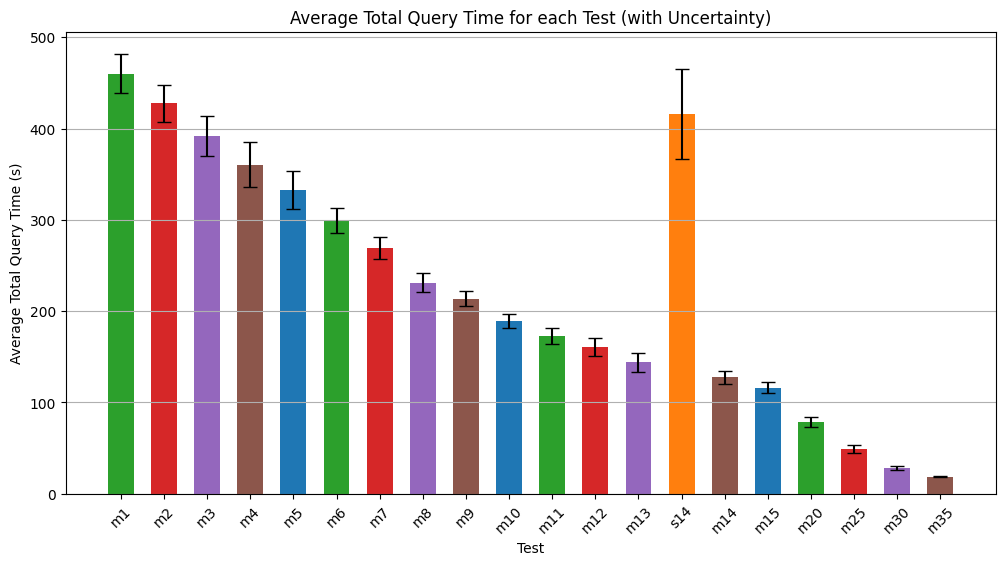

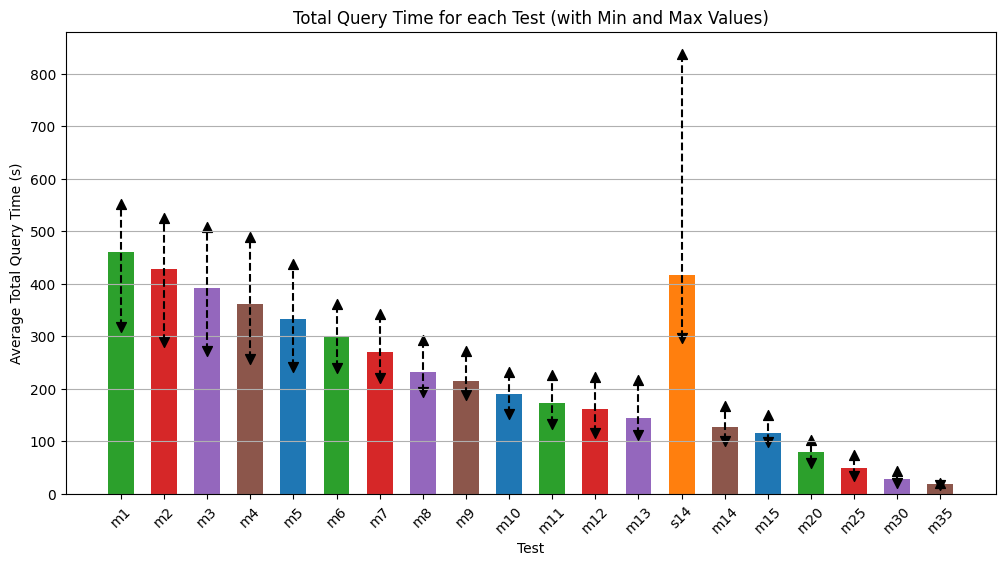

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Define new color mapping for all tests (adjust as needed)
colors = {
    "schema_based_materialization": "#FF7F0E",  # Bright orange for clear visibility

    "load_based_m0":  "#1f77b4",  # Blue
    "load_based_m1":  "#2ca02c",  # Green
    "load_based_m2":  "#d62728",  # Red
    "load_based_m3":  "#9467bd",  # Purple
    "load_based_m4":  "#8c564b",  # Brown

    "load_based_m5":  "#1f77b4",  # Blue
    "load_based_m6":  "#2ca02c",  # Green
    "load_based_m7":  "#d62728",  # Red
    "load_based_m8":  "#9467bd",  # Purple
    "load_based_m9":  "#8c564b",  # Brown

    "load_based_m10": "#1f77b4",  # Blue
    "load_based_m11": "#2ca02c",  # Green
    "load_based_m12": "#d62728",  # Red
    "load_based_m13": "#9467bd",  # Purple
    "load_based_m14": "#8c564b",  # Brown

    "load_based_m15": "#1f77b4",  # Blue
    "load_based_m20": "#2ca02c",  # Green
    "load_based_m25": "#d62728",  # Red
    "load_based_m30": "#9467bd",  # Purple
    "load_based_m35": "#8c564b",  # Brown
}

# Define the test order using all keys from the colors dictionary
test_order = list(colors.keys())

def shorten_label_into_number(test):
    if test == "schema_based_materialization":
        return 20
    elif test.startswith("load_based_"):
        return int((test.split("_")[-1])[1:])
    else:
        return test

# Filter the DataFrame for the tests in test_order
df_current = meta_results[meta_results["Test"].isin(test_order)].copy()

# Group by Test to compute statistics for Total query time
grouped_total_query_time = df_current.groupby("Test")["Total query time"].agg(
    mean="mean", std="std", count="count", max="max", min="min"
).reset_index()
grouped_total_query_time["stderr"] = grouped_total_query_time["std"] / np.sqrt(grouped_total_query_time["count"])

# Ensure that the tests are ordered as in test_order (this line is kept if needed for other purposes)
grouped_total_query_time["Test"] = pd.Categorical(
    grouped_total_query_time["Test"], categories=test_order, ordered=True
)

# Instead of sorting by mean, we sort by the numeric value from shorten_label_into_number
grouped_total_query_time.sort_values(
    "Test", key=lambda col: col.map(shorten_label_into_number)
, inplace=True)
# Helper function to shorten the labels
def shorten_label(test):
    if test == "schema_based_materialization":
        return "s16"
    elif test.startswith("load_based_"):
        return test.split("_")[-1]
    else:
        return test

# Create the list of shortened labels
short_labels = [shorten_label(test) for test in grouped_total_query_time["Test"]]

# Common x positions and bar width
x = np.arange(len(grouped_total_query_time))
bar_width = 0.6

# Define plot configurations in a loop
plot_configs = [
    {"mode": "errorbar", "title": "Average Total Query Time for each Test (with Uncertainty)"},
    {"mode": "minmax", "title": "Total Query Time for each Test (with Min and Max Values)"}
]

for config in plot_configs:
    fig, ax = plt.subplots(figsize=(12, 6))
    mode = config["mode"]
    
    if mode == "errorbar":
        # Plot bars with error bars for standard error
        ax.bar(
            x,
            grouped_total_query_time["mean"],
            bar_width,
            color=[colors[test] for test in grouped_total_query_time["Test"]],
            yerr=grouped_total_query_time["stderr"],
            capsize=5
        )
    elif mode == "minmax":
        # Plot bars without error bars
        ax.bar(
            x,
            grouped_total_query_time["mean"],
            bar_width,
            color=[colors[test] for test in grouped_total_query_time["Test"]],
            capsize=5
        )
        # Overlay dashed lines and markers for min and max values
        for i, (_, row) in enumerate(grouped_total_query_time.iterrows()):
            ax.plot([x[i], x[i]], [row["min"], row["max"]],
                    linestyle="--", color="black", linewidth=1.5)
            ax.scatter(x[i], row["min"], color="black", marker="v", s=50)
            ax.scatter(x[i], row["max"], color="black", marker="^", s=50)
    
    ax.set_xticks(x)
    ax.set_xticklabels(short_labels, rotation=45)
    ax.set_xlabel("Test")
    ax.set_ylabel("Average Total Query Time (s)")
    ax.set_title(config["title"])
    ax.grid(True, axis='y')


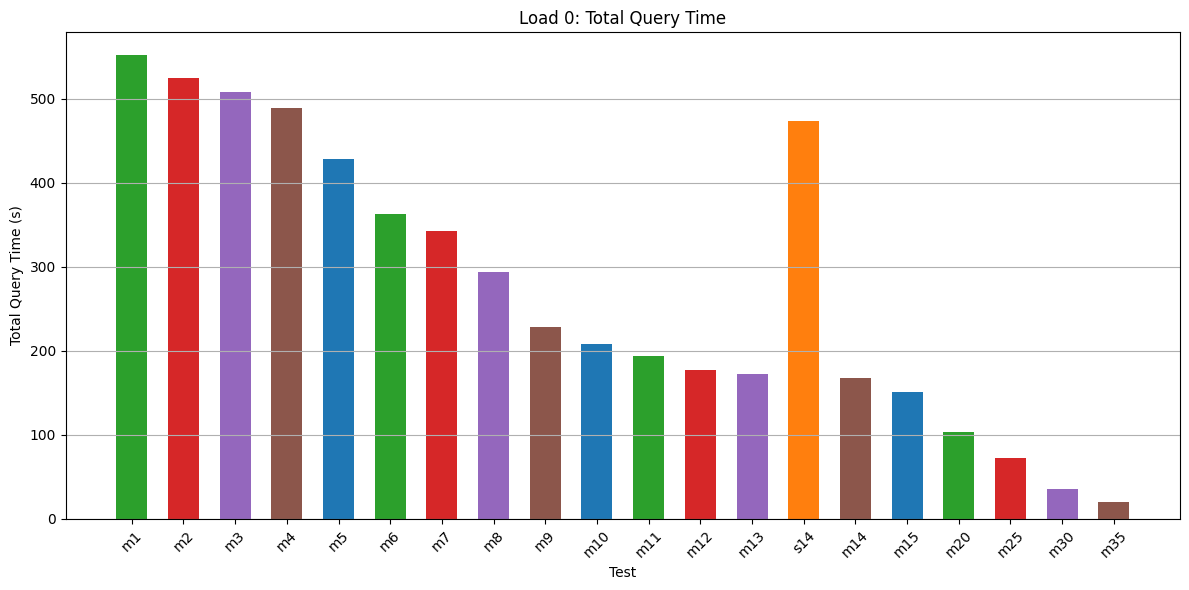

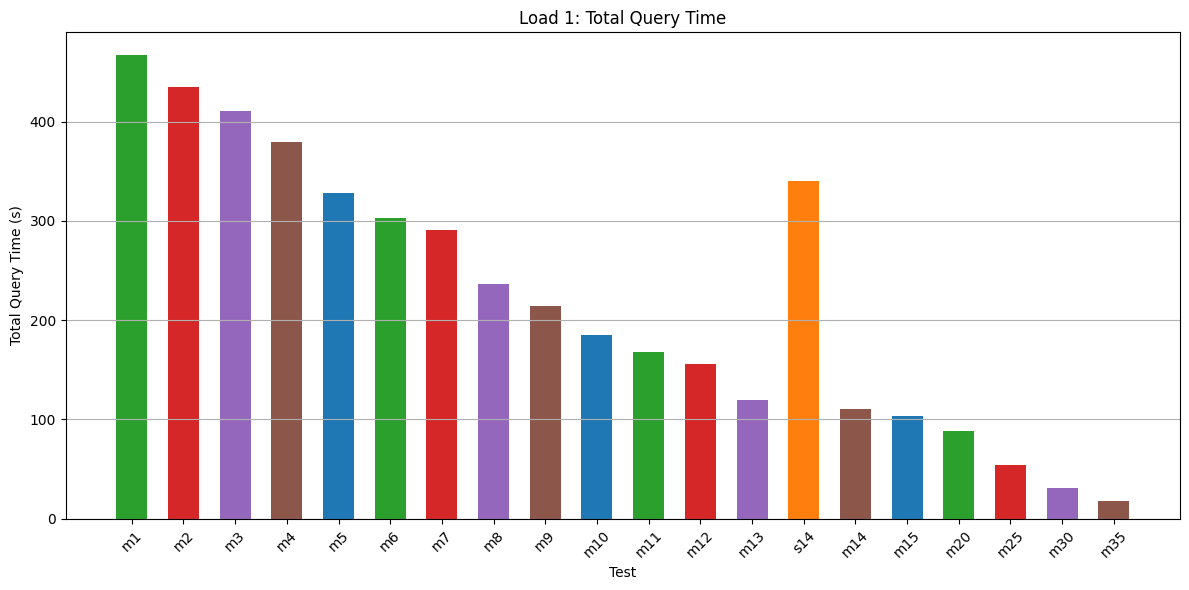

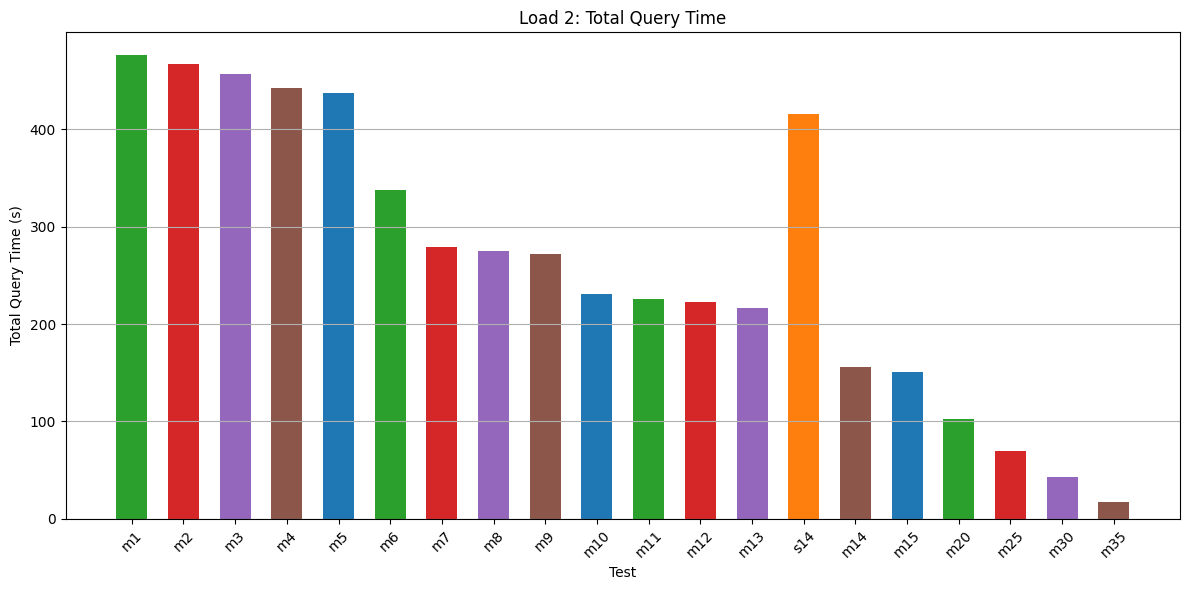

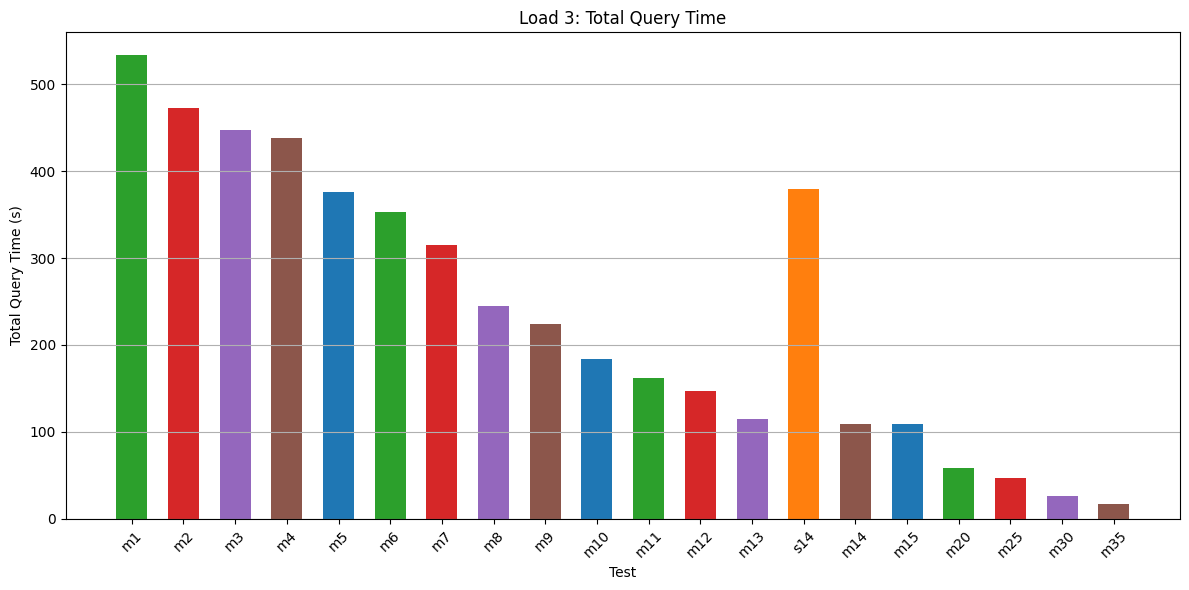

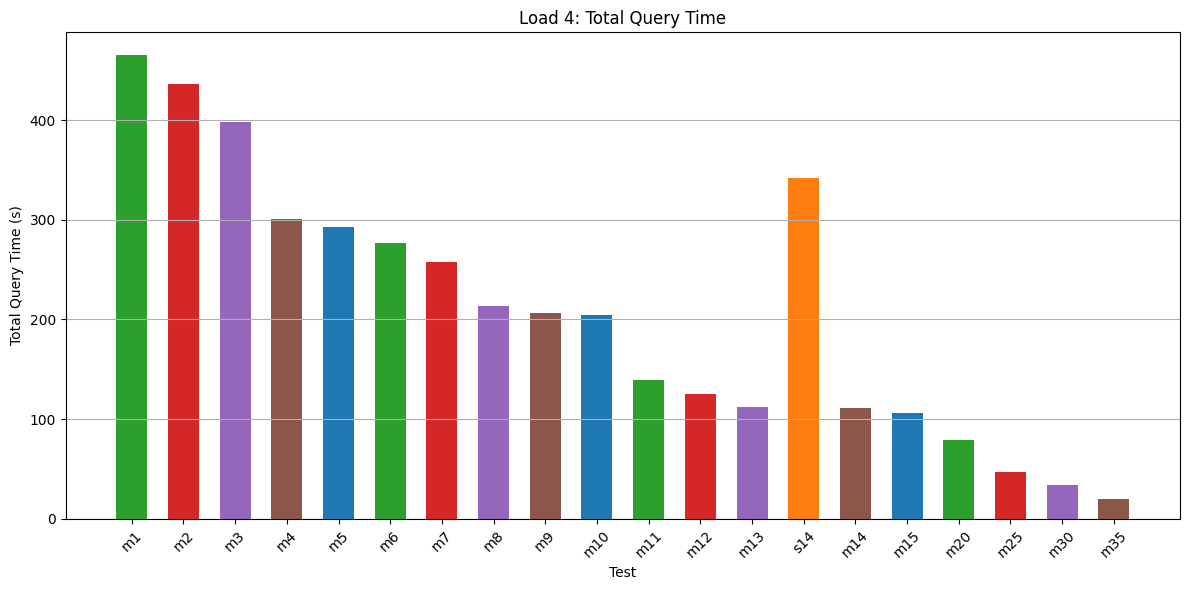

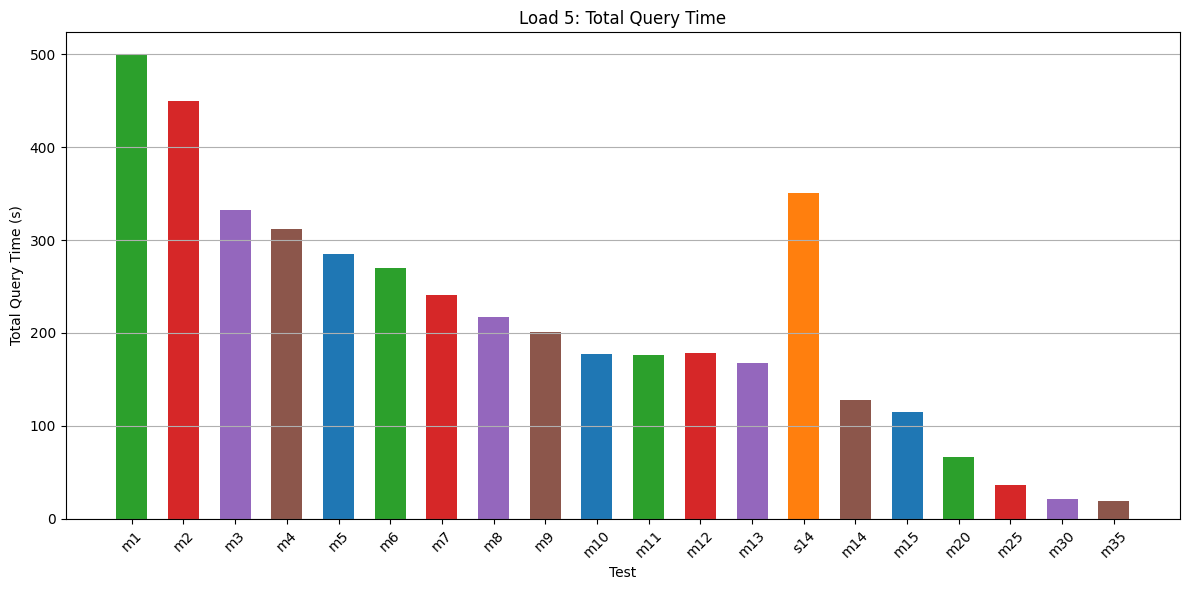

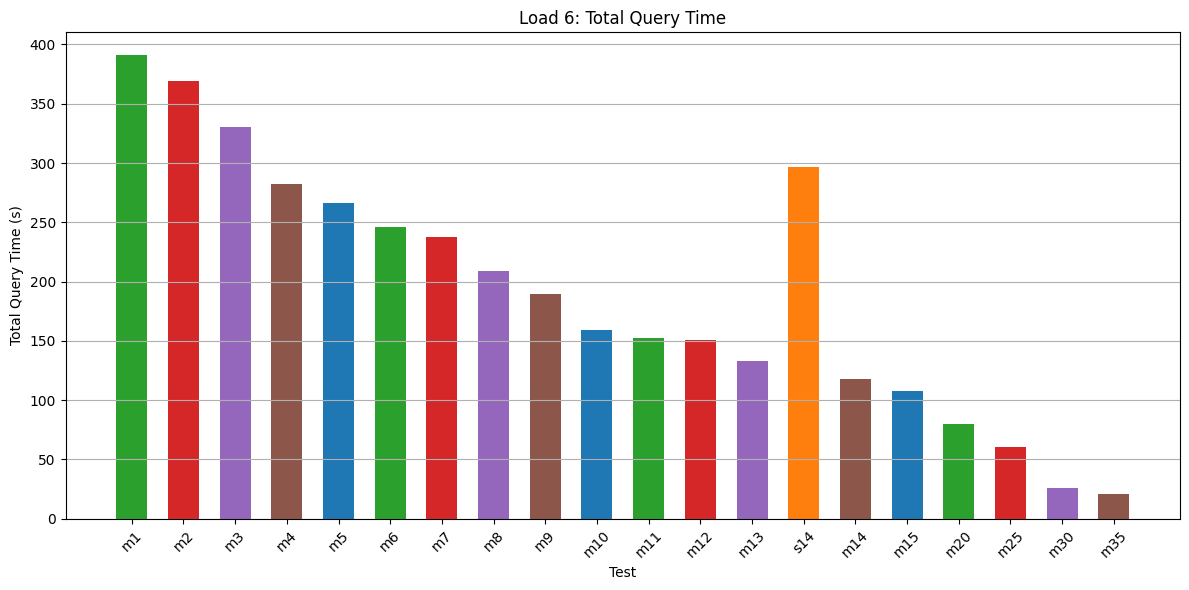

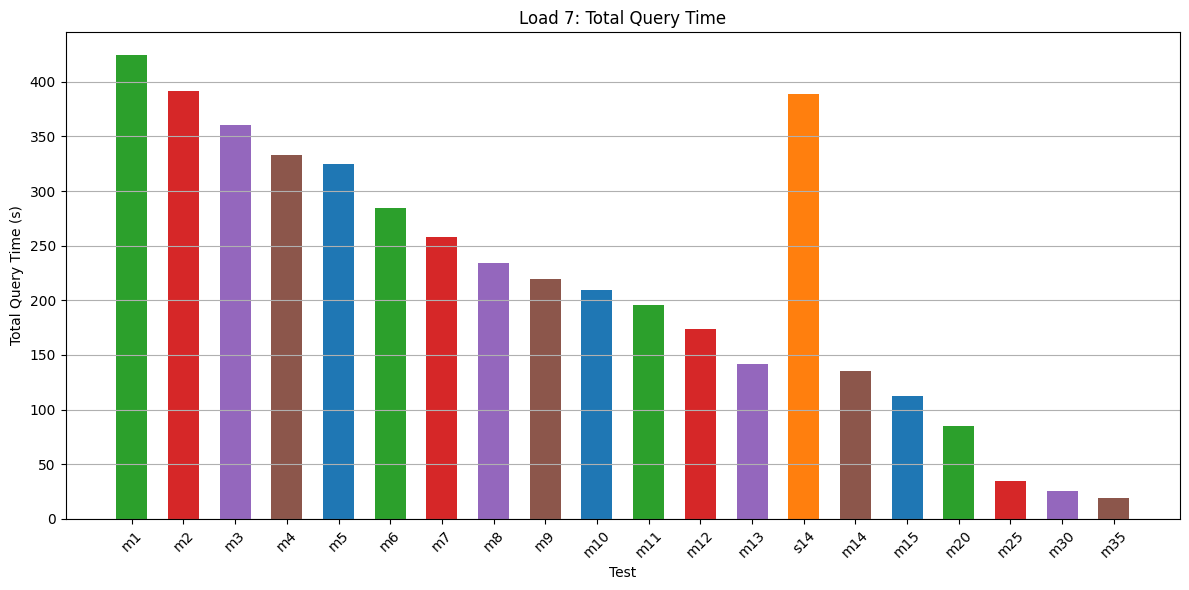

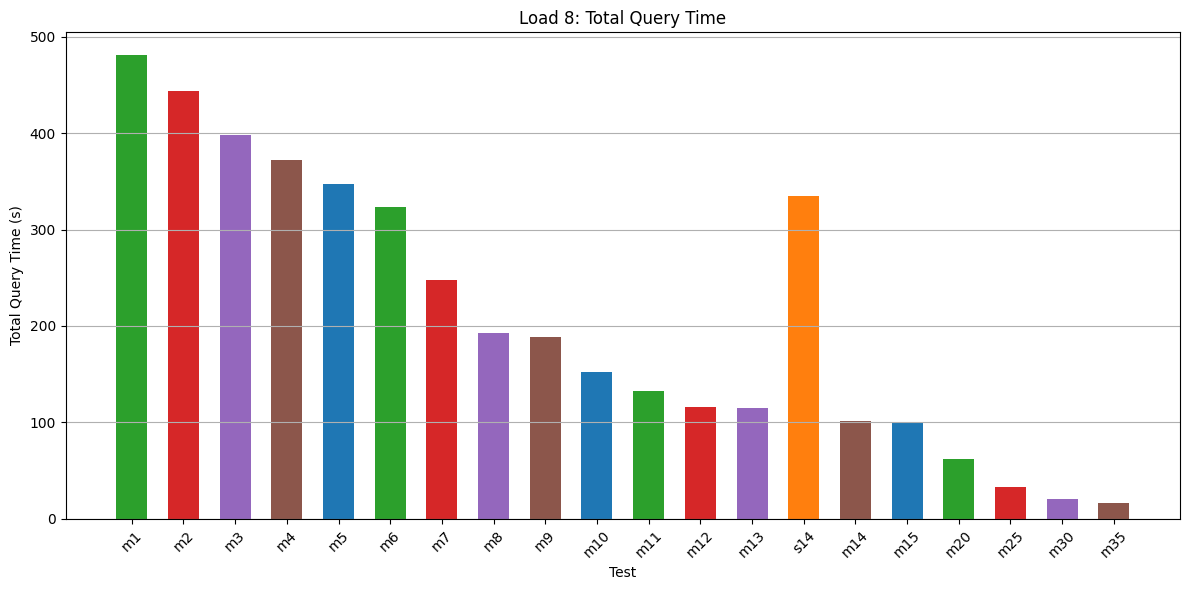

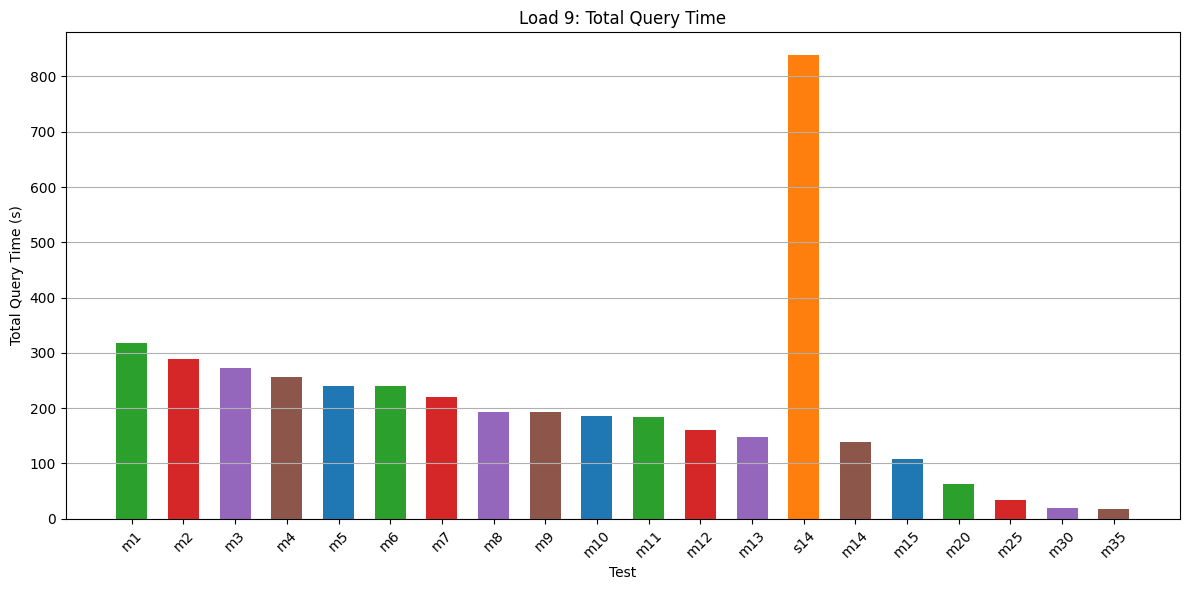

In [8]:
# Define the test order using all keys from the colors dictionary
test_order = list(colors.keys())


# Loop over each load value (0 to 9)
for load in range(10):
    # Filter the DataFrame for the current load and tests in test_order
    df_load = meta_results[(meta_results["Load"] == load) & (meta_results["Test"].isin(test_order))].copy()
    
    # Ensure tests are ordered as defined in test_order
    df_load["Test"] = pd.Categorical(df_load["Test"], categories=test_order, ordered=True)

    # Instead of sorting by mean, we sort by the numeric value from shorten_label_into_number
    df_load = df_load.sort_values(by="Test", key=lambda col: col.map(shorten_label_into_number))
    
    # Create shortened labels for x-axis
    short_labels = [shorten_label(test) for test in df_load["Test"]]
    
    # Define positions and bar width
    x = np.arange(len(df_load))
    bar_width = 0.6

    # Create a new figure for the current load
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot bars using raw "Total query time" values
    ax.bar(
        x,
        df_load["Total query time"],
        bar_width,
        color=[colors[test] for test in df_load["Test"]]
    )
    
    # Set x-axis labels and titles
    ax.set_xticks(x)
    ax.set_xticklabels(short_labels, rotation=45)
    ax.set_xlabel("Test")
    ax.set_ylabel("Total Query Time (s)")
    ax.set_title(f"Load {load}: Total Query Time")
    ax.grid(True, axis="y")
    plt.tight_layout()
    plt.show()


## Notes for Magnus
    Q15 - 122
    q20 - 101 - Spør om L
    Q9 - 89 - Spør litt om L
    Q12 - 88 - Spør mye om L 

